In [7]:
import pandahouse
import pandas as pd
import scipy.stats as stats 
from scipy.stats import norm, ttest_ind
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import hashlib # Делать хеши
import swifter # Для ускорения метода apply
from tqdm import tqdm # Для отслеживания прогресса

In [8]:
#создаём генератор псевдослучайных чисел
rng = np.random.default_rng()

In [9]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250520'
}

#Просмотры views на 1 пользователя в течение недели

q = """
SELECT views, count() as users
FROM
(SELECT  
    user_id,
    sum(action = 'view') as views
FROM simulator_20250520.feed_actions 
WHERE toDate(time) >= '2025-04-25' and toDate(time) <= '2025-05-01'
GROUP BY user_id
)
GROUP BY views
"""

views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [10]:
#общее количество пользователей
views_distribution.users.sum()

41997

In [11]:
#нормируем на общее число всех пользователей, получаем вероятность этого значения
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
56,16,545,0.012977
49,15,537,0.012787
116,14,500,0.011906
265,35,485,0.011548
16,30,469,0.011167
...,...,...,...
184,290,1,0.000024
276,321,1,0.000024
23,319,1,0.000024
87,295,1,0.000024


In [12]:
#Наше настоящее распределение просмотров (до применения алгоритма) сделаем дискретным.
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [13]:
#cреднее число просмотров = 70
views_distr.mean()

70.30916494035289

In [14]:
#среднее число просмотров по сгенерированной выборке при размере 100 = 75 - выше, при 1000 - 71,8 - уже лучше
views_distr.rvs(size = 1000).mean() 

71.462

In [15]:
#медиана просмотров = 60
views_distr.median()

60.0

In [16]:
#стандартное отклонение = 46,8
views_distr.std()

46.795649294309676

<AxesSubplot:ylabel='Count'>

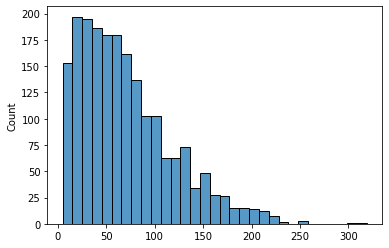

In [17]:
#Построим гистограмму просмотров
sns.histplot(views_distr.rvs(size=2000))

In [18]:
#CTR за неделю

q = """
SELECT
floor(ctr, 2) as ctr, 
count() as users 

FROM 
(SELECT toDate(time) as dt,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
FROM simulator_20250520.feed_actions
WHERE toDate(time) >= '2025-04-25' and toDate(time) <= '2025-05-01'
GROUP BY dt, user_id
)
GROUP BY ctr
"""
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [19]:
#нормируем на общее число всех пользователей - получаем вероятность этого значения
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,4993,0.058658
33,0.16,4233,0.049729
50,0.25,4216,0.049529
6,0.18,4213,0.049494
72,0.21,3957,0.046487
...,...,...,...
12,0.81,2,0.000023
73,0.83,1,0.000012
20,0.73,1,0.000012
51,1.00,1,0.000012


In [20]:
ctr_distribution['p']

0     0.016952
1     0.000047
2     0.000059
3     0.000047
4     0.000846
        ...   
75    0.001010
76    0.045253
77    0.003184
78    0.000752
79    0.028183
Name: p, Length: 80, dtype: float64

In [21]:
#Наше настоящее распределение CTR до применения алгоритма сделаем дискретным
ctr_distr = stats.rv_discrete(name='ctr_distr', 
                                values=(ctr_distribution['ctr'], 
                                        ctr_distribution['p']))

In [22]:
#cреднее значение CTR = 0,21
ctr_distr.mean()

0.21222988451733416

In [24]:
#количество симуляций = 20000 
num_simulations = 20000
num_group = round(views_distribution.users.sum()/2)
p_values = [] #все значения
for _ in tqdm(range(num_simulations)):
    group_A_views = rng.choice(views_distribution['views'], size=num_group, replace=True, p=views_distribution['p']).astype(np.int64)
    group_B_views = rng.choice(views_distribution['views'], size=num_group, replace=True, p=views_distribution['p']).astype(np.int64)
    group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=num_group) * (1 + rng.binomial(n=1, p=0.5, size=num_group)) *  (group_B_views >= 50))
    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=num_group, replace=True, p=ctr_distribution['p'])    
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=num_group, replace=True, p=ctr_distribution['p'])
    group_A_likes = rng.binomial(group_A_views, group_A_ctr)
    group_B_likes = rng.binomial(group_B_views, group_B_ctr) 
    p_values.append(stats.ttest_ind(group_A_likes, group_B_likes, equal_var=False).pvalue)

100%|██████████| 20000/20000 [04:17<00:00, 77.79it/s]


In [25]:
p_values[0:5]

[0.6749829885248804,
 0.4463049693342097,
 0.8138719044076331,
 0.1550497080541787,
 0.14806155613395452]

In [26]:
#мощность теста
round((np.mean(np.array(p_values) < 0.05)*100), 1)

25.9